In [1]:
import sys
import glob,os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
sys.path.append("../")
import utils.data_utils as du
import utils.visualization_utils as vu

# Data exploration and finding parameters to skim light-curves

1. time: get a light-curve with time span similar to training sample
2. S/N: maglims are not computed here, although we trained with them, maybe real data has larger S/N than sims
3. multiseason transients: although BRNNs should deal with this, eliminating crappy lcs should be good for overall efficiency.

In [2]:
# Init paths
path_raw = os.environ.get("DES_DATA")
path_dump = './dump/data_skimming/'

In [3]:
# config
# debug 
debug = False

In [4]:
# load data
# do run: process_Data_for_notebooks.py first! the notebook crashes with such large data to process
df_real = du.load_all_data('dummy','../dumps/preprocessed/real/', redo_photometry =False)
df_fake = du.load_all_data('dummy','../dumps/preprocessed/fake/', redo_photometry =False)

[Loading preprocessed data ../dumps/preprocessed/real/ ] 
[Loading preprocessed data ../dumps/preprocessed/fake/ ] 


In [5]:
# fixed in the load_all_data utility
# BEWARE! SNID for fakes is actually NOT the real SNID 
# df_fake['SNID']= df_fake['PRIVATE(DES_snid)']

31645

In [5]:
# Compute some general info
print("Real light-curves",len(df_real["SNID"].unique()))
df_real['S/N'] = df_real['FLUXCAL']/df_real['FLUXCALERR']
print("Fake light-curves",len(df_fake["SNID"].unique()))
df_fake['S/N'] = df_fake['FLUXCAL']/df_fake['FLUXCALERR']

Real light-curves 31645
Fake light-curves 42826


In [7]:
if df_fake.MJD.values[0] == -777.0:
    df_fake = df_fake.drop(df_fake.index[0])
if df_real.MJD.values[0] == -777.0:
    df_real = df_real.drop(df_real.index[0])

# Data exploration
distribution of available variables

0.0     17986655
16.0     2427069
4.0      2050686
8.0      2035427
Name: PRIVATE(DES_transient_status), dtype: int64


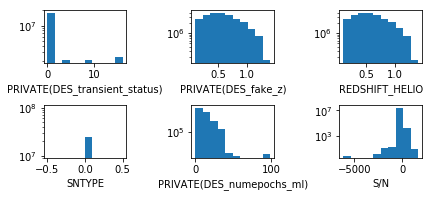

In [67]:
# Variable inspection
# general dist
list_var = ['PRIVATE(DES_transient_status)','PRIVATE(DES_fake_z)','REDSHIFT_HELIO','SNTYPE','PRIVATE(DES_numepochs_ml)',"S/N"]
fig = plt.figure()
for i,var in enumerate(list_var):
    ax=plt.subplot(3,3,i+1)
    ax.hist(df_fake[var])
    ax.set_yscale("log")
    ax.set_xlabel(var)
fig.tight_layout()
fig.subplots_adjust(top=0.88)
# all Ias and no transient status
# print(df_fake['PRIVATE(DES_transient_status)'].unique(),df_fake['SNTYPE'].unique())
print(df_fake['PRIVATE(DES_transient_status)'].value_counts())
# print(df_fake['PRIVATE(DES_numepochs_ml)'].value_counts())

Fakes asre only type Ia

So basically this means that transient_status:
- (False) if it was properly run on fakes then it is not a good indicator of the good light-curves
- (True) if it wasnt properly run, either rerun it or not use it in fakes, only in data 
- I could see if I construct my own transient status with numepochs. To be done next week (~April 20th) with Mat Smith

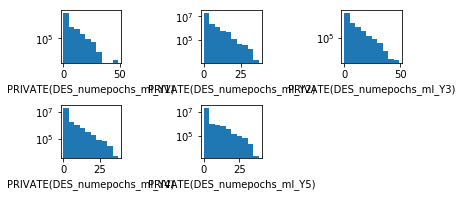

In [68]:
# ML Real Bogus
list_var_ML = ['PRIVATE(DES_numepochs_ml_Y1)','PRIVATE(DES_numepochs_ml_Y2)','PRIVATE(DES_numepochs_ml_Y3)','PRIVATE(DES_numepochs_ml_Y4)','PRIVATE(DES_numepochs_ml_Y5)']
fig = plt.figure()
for i,var in enumerate(list_var_ML):
    ax=plt.subplot(3,3,i+1)
    ax.hist(df_fake[var])
    ax.set_yscale("log")
    ax.set_xlabel(var)
#     print(var,df_fake[var].value_counts())
fig.tight_layout()
fig.subplots_adjust(top=0.88)

# Real vs Fake

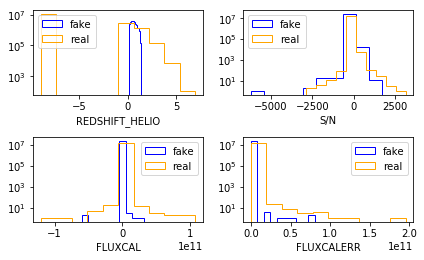

In [72]:
# parameter distribution
list_var = ["REDSHIFT_HELIO","S/N","FLUXCAL","FLUXCALERR"]
fig = plt.figure()
for i,var in enumerate(list_var):
    ax=plt.subplot(2,2,i+1)
    ax.hist(df_fake[var],histtype="step",color="blue",label='fake')
    ax.hist(df_real[var],histtype="step",color="orange",label="real")
    ax.set_xlabel(var)
    ax.set_yscale("log")
    ax.legend()
#     print(var,df_fake[var].value_counts())
fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.savefig("../dumps/general_figures/hist_fake_real.png")

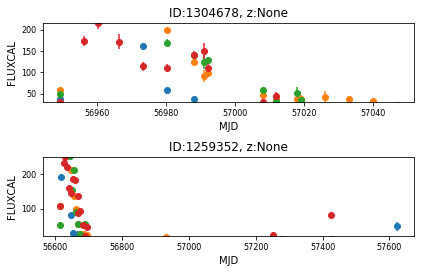

In [75]:
# plot some real light-curves 
import random
list_SNIDs = [df_real['SNID'].unique()[i] for i in sorted(random.sample(range(len(df_real['SNID'].unique())), 2))]
fig = plt.figure()
for i, sid in enumerate(list_SNIDs):
    ax = plt.subplot(2,1,i+1)
    df_real_tmp = df_real[df_real["S/N"]>3]
    vu.plot_single_lc(df_real_tmp,sid,ax,plot_peak=False)
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
plt.savefig("../dumps/general_figures/real_lcs_examples_wSNcut3_4.png")

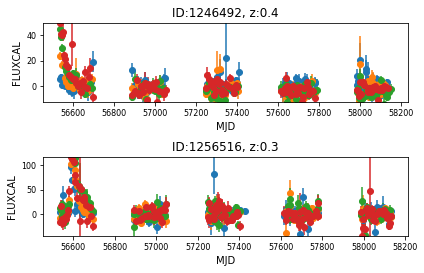

In [51]:
# plot some fake light-curves 
list_SNIDs = [df_fake['SNID'].unique()[i] for i in sorted(random.sample(range(len(df_fake['SNID'].unique())), 2))]
fig = plt.figure()
for i, sid in enumerate(list_SNIDs):
    ax = plt.subplot(2,1,i+1)
    vu.plot_single_lc(df_fake,sid,ax,plot_peak=True)
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
plt.savefig("../dumps/general_figures/fake_lcs_examples_3.png")

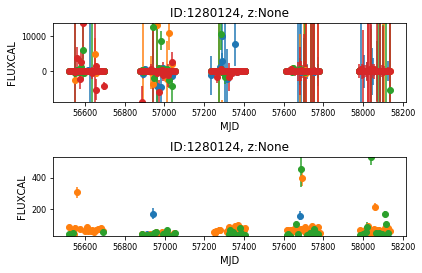

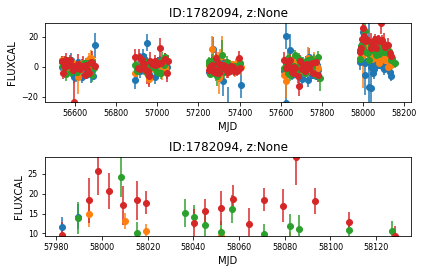

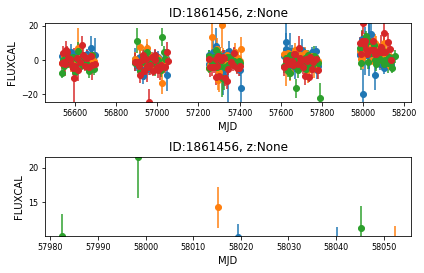

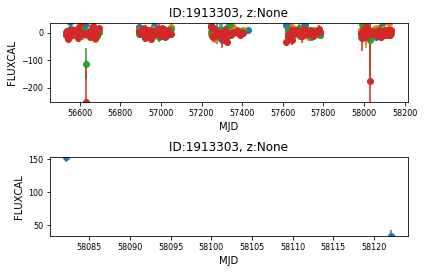

In [82]:
# plot some real light-curves w and wo S/N cut
list_SNIDs = [df_real['SNID'].unique()[i] for i in sorted(random.sample(range(len(df_real['SNID'].unique())),4))]
for i in range(4):
    fig = plt.figure()
    ax = plt.subplot(2,1,1)
    vu.plot_single_lc(df_real,list_SNIDs[i],ax,plot_peak=False)
    ax = plt.subplot(2,1,2)
    df_real_tmp = df_real[df_real["S/N"]>3]
    vu.plot_single_lc(df_real_tmp,list_SNIDs[i],ax,plot_peak=False)
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    plt.savefig(f"../dumps/general_figures/real_lcs_examples_w_wo_SNcut3_{i}.png")

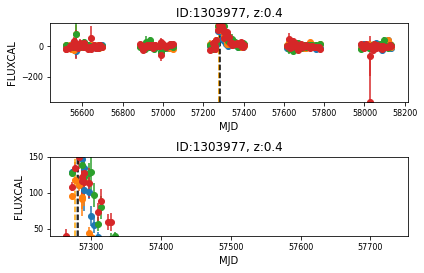

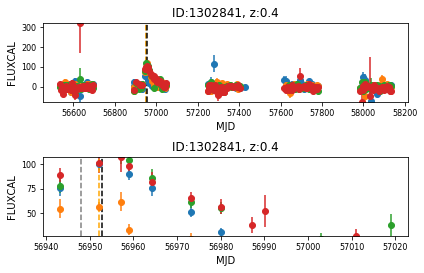

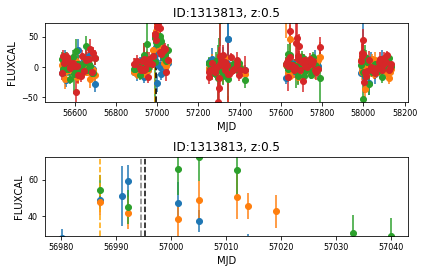

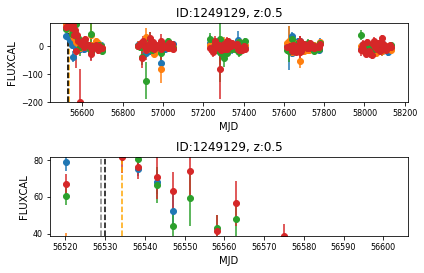

In [80]:
# plot some fake light-curves w and wo S/N cut
list_SNIDs = [df_fake['SNID'].unique()[i] for i in sorted(random.sample(range(len(df_fake['SNID'].unique())),4))]
for i in range(4):
    fig = plt.figure()
    ax = plt.subplot(2,1,1)
    vu.plot_single_lc(df_fake,list_SNIDs[i],ax,plot_peak=True)
    ax = plt.subplot(2,1,2)
    df_fake_tmp = df_fake[df_fake["S/N"]>3]
    vu.plot_single_lc(df_fake_tmp,list_SNIDs[i],ax,plot_peak=True)
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    plt.savefig(f"../dumps/general_figures/fake_lcs_examples_w_wo_SNcut3_{i}.png")

# Time window

1. Compute delta time. This is an exploration, if applying cuts need to do a hack for maintaining photometry separators (see peak exploration notebook for more info).

In [8]:
def compute_delta_time(df):
    """Compute the delta time between two consecutive observations

    Args:
        df (pandas.DataFrame): dataframe holding lightcurve data

    Returns:
        (pandas.DataFrame) dataframe holding lightcurve data with delta_time features
    """

    df["delta_time"] = df["MJD"].diff()
    # Fill the first row with 0 to replace NaN
    df.delta_time = df.delta_time.fillna(0)
    try:
        IDs = df.SNID.values
    # Deal with the case where lightcrv_ID is the index
    except AttributeError:
        assert df.index.name == "SNID"
        IDs = df.index.values
    # Find idxs of rows where a new light curve start then zero delta_time
    idxs = np.where(IDs[:-1] != IDs[1:])[0] + 1
    arr_delta_time = df.delta_time.values
    arr_delta_time[idxs] = 0
    df["delta_time"] = arr_delta_time

    return df

In [9]:
df_fake = compute_delta_time(df_fake.copy())
df_real = compute_delta_time(df_real.copy())

## Window: trigger time
If we select a time window around trigger time, is it good? See peak exploration notebook for more info.

In [94]:
df_fake['delta_trigger'] = df_fake['MJD']-df_fake['PRIVATE(DES_mjd_trigger)']
df_fake['trigger_window']=df_fake["delta_trigger"].apply(lambda x: True if (x>0 and x<70) else (True if (x<=0 and x>-30) else False))

In [102]:
# [k for k in df_fake.keys()]

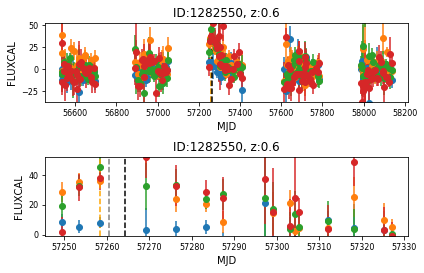

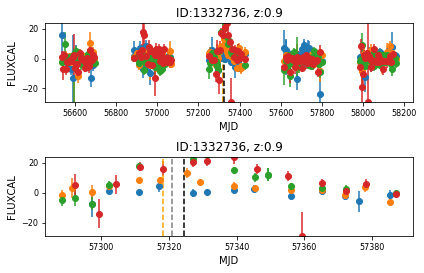

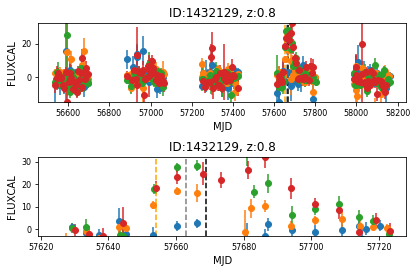

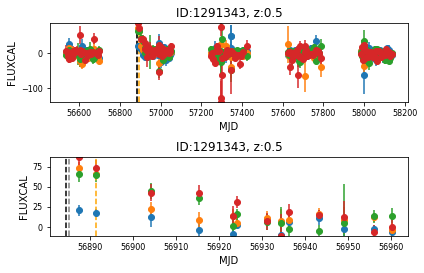

In [101]:
# plot some fake light-curves w/wo time window
list_SNIDs = [df_fake['SNID'].unique()[i] for i in sorted(random.sample(range(len(df_fake['SNID'].unique())),4))]
for i in range(4):
    fig = plt.figure()
    ax = plt.subplot(2,1,1)
    vu.plot_single_lc(df_fake,list_SNIDs[i],ax,plot_peak=True)
    ax = plt.subplot(2,1,2)
    df_fake_tmp = df_fake[df_fake["trigger_window"]==True]
    vu.plot_single_lc(df_fake_tmp,list_SNIDs[i],ax,plot_peak=True)
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    plt.savefig(f"../dumps/general_figures/fake_lcs_w_wo_triggerwindow_{i}.png")

# Subseason
Split subseasons when delta_time >100 days, should be ok. Lets visualize a subseason split with an example. 

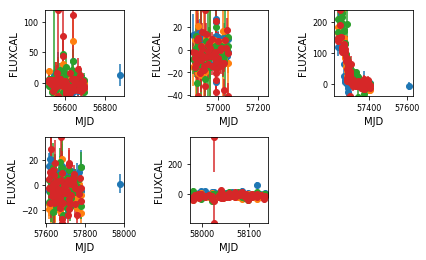

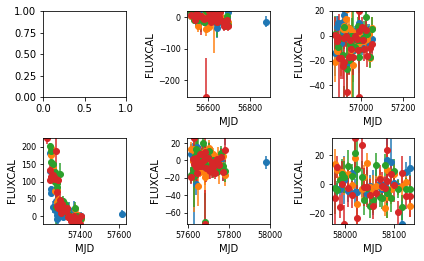

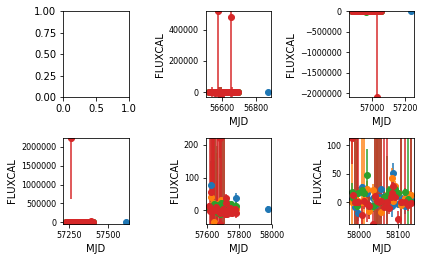

In [11]:
# example of subseason split
for i in range(3):
    sid = df_fake["SNID"].unique()[i]
    dummy = df_fake[ (df_fake['SNID']==sid)]
    subseason = [dummy.index[0]] + dummy.index[dummy['delta_time'] >100].tolist() + [dummy.index[-1]]
    dic_dummy = {}
    for i in range(len(subseason)-1):
        dic_dummy[i] = dummy.loc[subseason[i]:subseason[i+1]]
    fig = plt.figure()
    for i in range(len(dic_dummy)):
        ax = plt.subplot(2,3,i+1)
        vu.plot_single_lc(dic_dummy[i],sid,ax,plot_peak=False, no_title=True)
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    plt.savefig(f"../dumps/general_figures/fake_lcs_subseason_{i}.png")
    del fig

LCs look good but, would supernnova be able to handle lcs that start maybe 100 days after the "subseason" starts?
Also, how should I identify these lcs? SNID is an int, maybe convert it to float?

In [19]:
dummy

,SNID,MJD,FLT,FIELD,PHOTFLAG,PHOTPROB,FLUXCAL,FLUXCALERR,PSF_SIG1,PSF_SIG2,...,PRIVATE(DES_fake_hostmag_r),HOSTGAL_NMATCH,PRIVATE(DES_mjd_latest_ml),HOSTGAL_MAG_r,SEARCH_TYPE,VPEC_ERR,HOSTGAL_SB_FLUXCAL_z,PRIVATE(DES_numepochs_ml_Y5),delta_time,S/N
1743,1273097,-777.000,-,b'XXXX ',1,-9.0,-777.000000,-777.000000,2.306,0.0,...,22.16,0,57334.19,0.0,0,0.0,0.0,0.0,0.000,1.000000
1744,1273097,56520.222,g,b'E1 ',1,-9.0,-0.164710,4.831900,1.891,0.0,...,22.16,0,57334.19,0.0,0,0.0,0.0,0.0,57297.222,-0.034088
1745,1273097,56520.225,r,b'E1 ',1,-9.0,0.053766,4.434400,1.696,0.0,...,22.16,0,57334.19,0.0,0,0.0,0.0,0.0,0.003,0.012125
1746,1273097,56520.227,i,b'E1 ',1,-9.0,3.824100,4.713900,1.513,0.0,...,22.16,0,57334.19,0.0,0,0.0,0.0,0.0,0.002,0.811239
1747,1273097,56520.229,z,b'E1 ',1,-9.0,6.923600,6.161900,1.605,0.0,...,22.16,0,57334.19,0.0,0,0.0,0.0,0.0,0.002,1.123615
1748,1273097,56534.154,g,b'E1 ',2049,-9.0,1.982600,2.682000,2.108,0.0,...,22.16,0,57334.19,0.0,0,0.0,0.0,0.0,13.925,0.739224
1749,1273097,56534.157,r,b'E1 ',2049,-9.0,-6.686600,4.100000,2.045,0.0,...,22.16,0,57334.19,0.0,0,0.0,0.0,0.0,0.003,-1.630878
1750,1273097,56534.159,i,b'E1 ',2049,-9.0,-2.829200,5.934300,2.057,0.0,...,22.16,0,57334.19,0.0,0,0.0,0.0,0.0,0.002,-0.476754
1751,1273097,56534.161,z,b'E1 ',2049,-9.0,-23.517000,8.426600,2.224,0.0,...,22.16,0,57334.19,0.0,0,0.0,0.0,0.0,0.002,-2.790805
1752,1273097,56538.161,g,b'E1 ',1,-9.0,3.681900,3.178800,2.572,0.0,...,22.16,0,57334.19,0.0,0,0.0,0.0,0.0,4.000,1.158267


# fit Bazin function to lc? 

In [18]:
from scipy.optimize import curve_fit
def bazin_func(x, a, t0,tauf, taur,c):
    return (a* np.exp(-(x-t0)/tauf)/(1+np.exp(-(x-t0)/taur)))+c

In [19]:
popt={}
pcov={}
for i in range(len(dic_dummy)):
    tmp = dic_dummy[i]
    tmp = tmp[tmp["FLT"]=="i"]
    popt[i], pcov[i] = curve_fit(bazin_func,tmp['MJD'], tmp['FLUXCAL'],bounds=([0,tmp['MJD'].min(),-np.inf,-np.inf,-np.inf], [tmp["FLUXCAL"].max()*1.5,tmp['MJD'].max(),np.inf,np.inf,np.inf]))

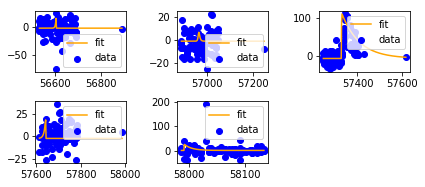

In [20]:
fig = plt.figure()
for i in range(len(dic_dummy)):
    ax=plt.subplot(3,3,i+1)
    tmp = dic_dummy[i]
    xx = np.linspace(tmp['MJD'].min(), tmp['MJD'].max(), 200)
    ax.scatter(tmp['MJD'], tmp['FLUXCAL'], color='blue',label="data")
    ax.plot(xx, bazin_func(xx, popt[i][0], popt[i][1], popt[i][2],popt[i][3],popt[i][4]), color='orange',label="fit")
    ax.legend()
fig.tight_layout()
fig.subplots_adjust(top=0.88)

In [21]:
[popt[i][0] for i in [0,1,2,3,4]]

[21.758927030461027,
 14.966398923395005,
 120.53508526330235,
 24.134459711135204,
 25.280363686635006]

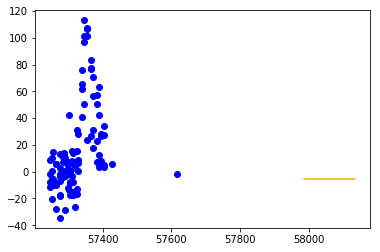

In [22]:
i=2
tmp = dic_dummy[i]
ax=plt.subplot()
ax.scatter(tmp['MJD'], tmp['FLUXCAL'], color='blue',label="data")
ax.plot(xx, bazin_func(xx, popt[i][0], popt[i][1], popt[i][2],popt[i][3],popt[i][4]), color='orange',label="fit")